In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# Download do dataset MNIST into data dir
! curl -o data/mnist_train.csv https://pjreddie.com/media/files/mnist_train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  104M  100  104M    0     0  8354k      0  0:00:12  0:00:12 --:--:-- 9208k


In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [5]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [7]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_filters_conv1=6,num_filters_conv2=12, num_hidden=64):
        super(CNN, self).__init__()
        self.num_filters_conv1 = num_filters_conv1
        self.num_filters_conv2 = num_filters_conv2
        self.conv1 = nn.Conv2d(1, num_filters_conv1, 5)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, 5)
        self.fc1 = nn.Linear(num_filters_conv2 * 4 * 4, num_hidden)
        self.fc2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_conv2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [8]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:00<00:00, 84.04it/s]


Epoch 1, Train Loss: 2.275, Train Accuracy: 14.20%
Epoch 1, Val Loss: 2.191, Val Accuracy: 28.60%


100%|██████████| 16/16 [00:00<00:00, 108.55it/s]


Epoch 2, Train Loss: 2.017, Train Accuracy: 31.80%
Epoch 2, Val Loss: 1.657, Val Accuracy: 53.80%


100%|██████████| 16/16 [00:00<00:00, 99.88it/s]


Epoch 3, Train Loss: 1.359, Train Accuracy: 53.10%
Epoch 3, Val Loss: 0.860, Val Accuracy: 73.40%


100%|██████████| 16/16 [00:00<00:00, 115.03it/s]


Epoch 4, Train Loss: 0.785, Train Accuracy: 73.20%
Epoch 4, Val Loss: 0.531, Val Accuracy: 83.00%


100%|██████████| 16/16 [00:00<00:00, 112.55it/s]


Epoch 5, Train Loss: 0.538, Train Accuracy: 83.00%
Epoch 5, Val Loss: 0.420, Val Accuracy: 86.20%
Treinamento concluído


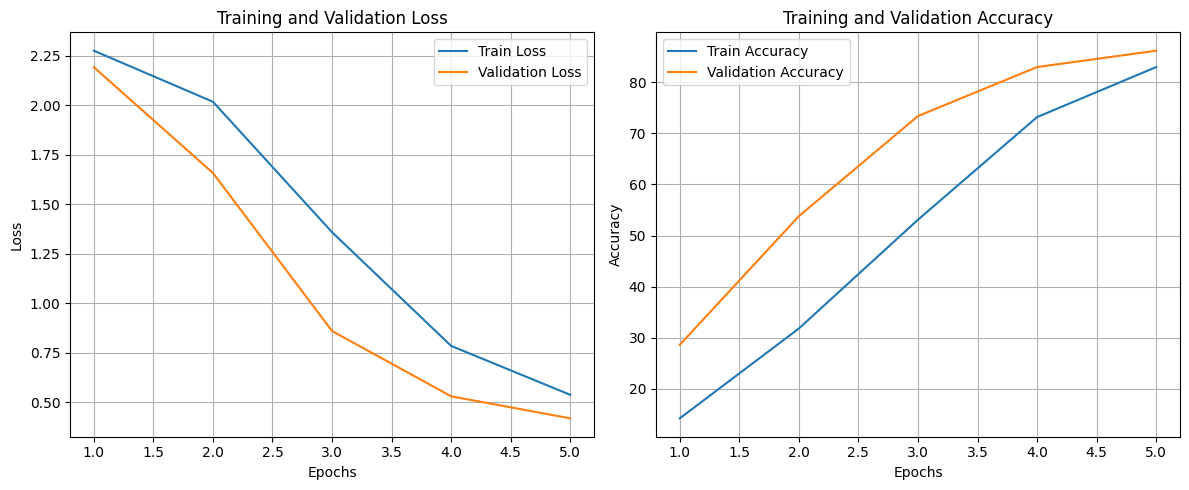

In [11]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
test_model(model, testloader)

Acurácia da rede na base de teste: 87.80%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

Failed to download (trying next):
<urlopen error [Errno 60] Operation timed out>



100%|██████████| 9.91M/9.91M [00:01<00:00, 7.75MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 60] Operation timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 265kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 60] Operation timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.72MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 60] Operation timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.09MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw


Testando configuração: Conv1=6, Conv2=12
Epoch 1/10:
Loss: 0.3276
Test Accuracy: 97.37%
--------------------------------------------------
Epoch 2/10:
Loss: 0.1026
Test Accuracy: 98.41%
--------------------------------------------------
Epoch 3/10:
Loss: 0.0749
Test Accuracy: 98.46%
--------------------------------------------------
Epoch 4/10:
Loss: 0.0607
Test Accuracy: 98.62%
--------------------------------------------------
Epoch 5/10:
Loss: 0.0529
Test Accuracy: 98.57%
--------------------------------------------------
Epoch 6/10:
Loss: 0.0460
Test Accuracy: 98.75%
--------------------------------------------------
Epoch 7/10:
Loss: 0.0435
Test Accuracy: 98.79%
--------------------------------------------------
Epoch 8/10:
Loss: 0.0383
Test Accuracy: 98.80%
--------------------------------------------------
Epoch 9/10:
Loss: 0.0349
Test Accuracy: 98.82%
--------------------------------------------------
Epoch

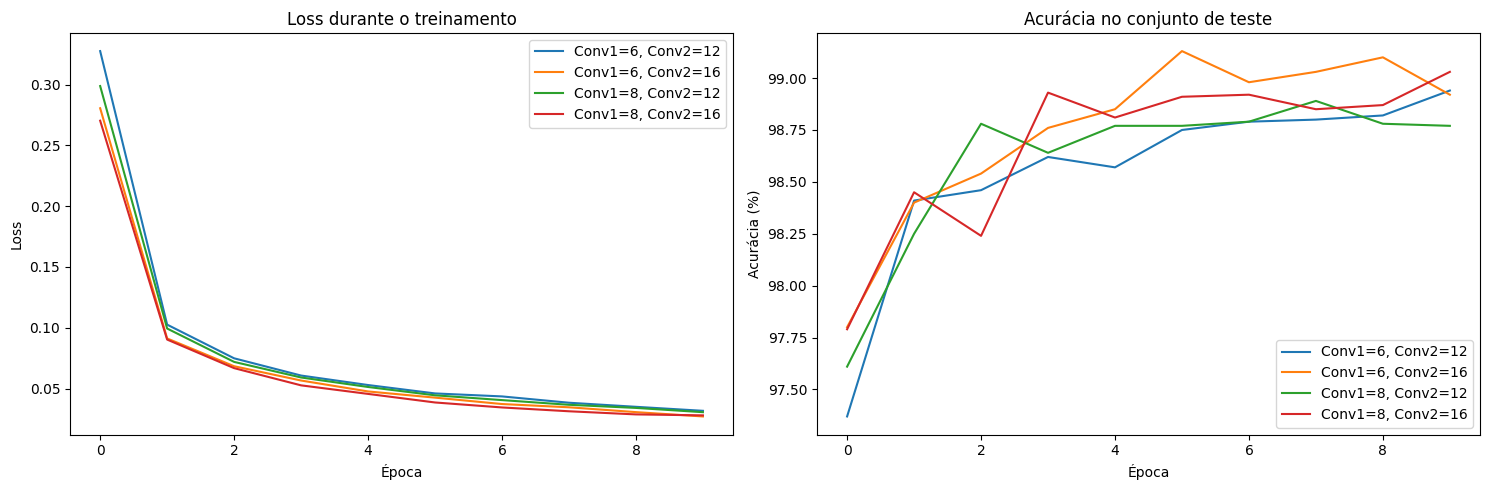


Resultados finais:
Conv1=6, Conv2=12: Acurácia final = 98.94%
Conv1=6, Conv2=16: Acurácia final = 98.92%
Conv1=8, Conv2=12: Acurácia final = 98.77%
Conv1=8, Conv2=16: Acurácia final = 99.03%


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, epochs=10, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    train_losses = []
    test_accuracies = []
    
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Avaliação no conjunto de teste
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Loss: {epoch_loss:.4f}')
        print(f'Test Accuracy: {accuracy:.2f}%')
        print('-' * 50)
    
    return train_losses, test_accuracies

# Configuração dos dados
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Configurações dos experimentos
configurations = [
    {'conv1': 6, 'conv2': 12},
    {'conv1': 6, 'conv2': 16},
    {'conv1': 8, 'conv2': 12},
    {'conv1': 8, 'conv2': 16}
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = {}

# Executando experimentos
for config in configurations:
    print(f"\nTestando configuração: Conv1={config['conv1']}, Conv2={config['conv2']}")
    
    model = CNN(
        num_filters_conv1=config['conv1'],
        num_filters_conv2=config['conv2']
    )
    
    train_losses, test_accuracies = train_model(
        model,
        train_loader,
        test_loader,
        epochs=10,
        device=device
    )
    
    results[f"Conv1={config['conv1']}, Conv2={config['conv2']}"] = {
        'train_losses': train_losses,
        'test_accuracies': test_accuracies,
        'final_accuracy': test_accuracies[-1]
    }

# Plotando resultados
plt.figure(figsize=(15, 5))

# Plot das perdas de treinamento
plt.subplot(1, 2, 1)
for config, data in results.items():
    plt.plot(data['train_losses'], label=config)
plt.title('Loss durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Plot das acurácias de teste
plt.subplot(1, 2, 2)
for config, data in results.items():
    plt.plot(data['test_accuracies'], label=config)
plt.title('Acurácia no conjunto de teste')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Imprimindo resultados finais
print("\nResultados finais:")
for config, data in results.items():
    print(f"{config}: Acurácia final = {data['final_accuracy']:.2f}%")

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

Testando com 5 valores de neurônios: [62, 71, 106, 116, 125]

Testando modelo com 62 neurônios na camada escondida
Epoch 1/10:
Loss: 0.3733
Validation Accuracy: 96.68%
--------------------------------------------------
Epoch 2/10:
Loss: 0.1238
Validation Accuracy: 97.64%
--------------------------------------------------
Epoch 3/10:
Loss: 0.0883
Validation Accuracy: 98.00%
--------------------------------------------------
Epoch 4/10:
Loss: 0.0745
Validation Accuracy: 98.22%
--------------------------------------------------
Epoch 5/10:
Loss: 0.0620
Validation Accuracy: 98.16%
--------------------------------------------------
Epoch 6/10:
Loss: 0.0557
Validation Accuracy: 98.55%
--------------------------------------------------
Epoch 7/10:
Loss: 0.0484
Validation Accuracy: 98.57%
--------------------------------------------------
Epoch 8/10:
Loss: 0.0423
Validation Accuracy: 98.47%
--------------------------------------------------
Epoch 9/10:
Loss: 0.0405
Validation Accuracy: 98.60%


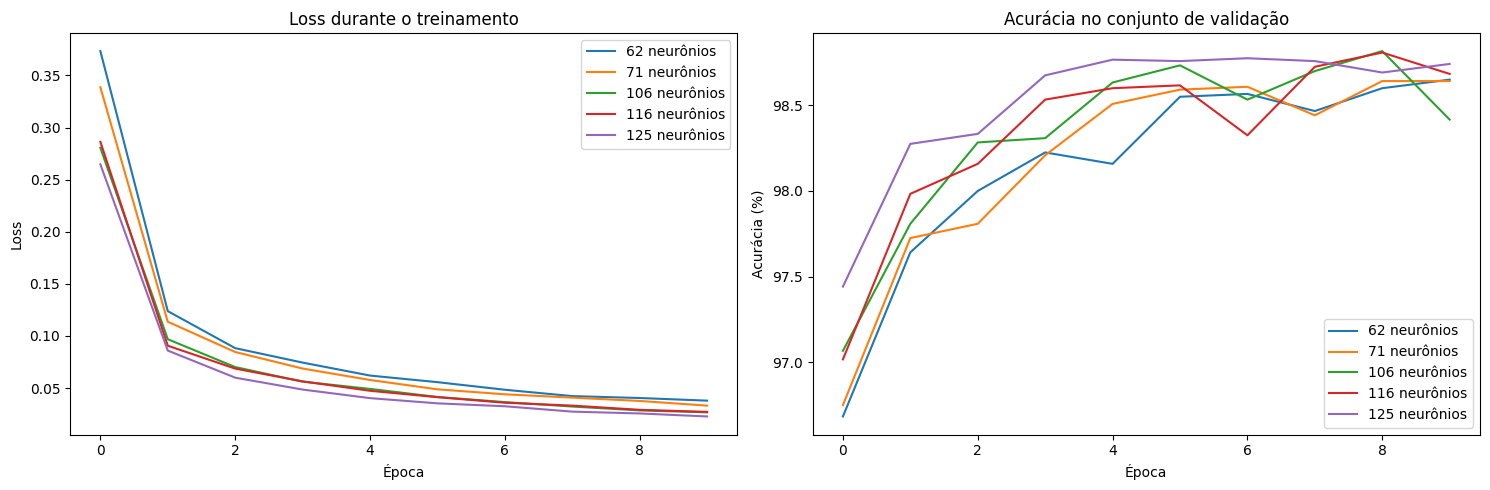

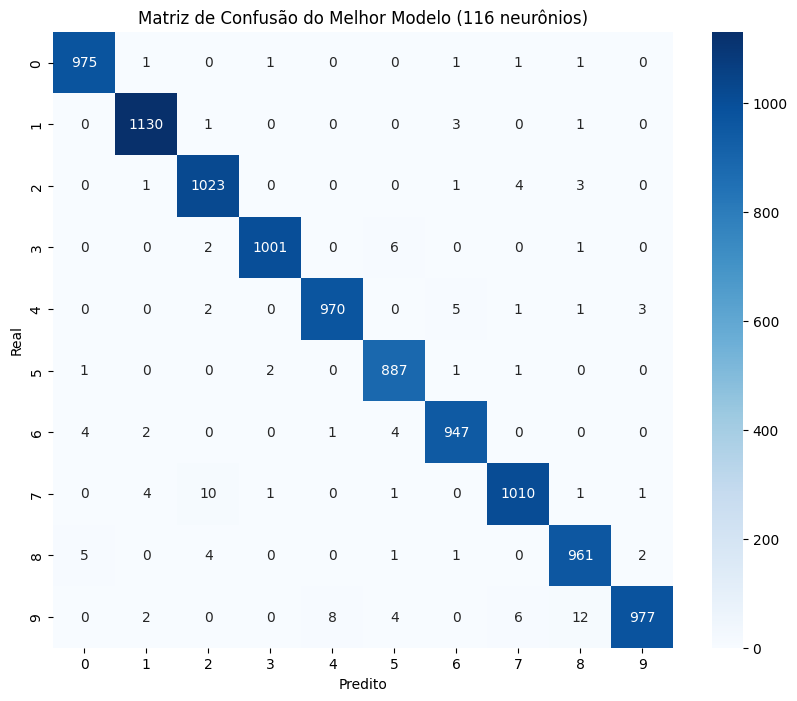


Resultados finais:
62 neurônios: Acurácia no teste = 98.76%
71 neurônios: Acurácia no teste = 98.80%
106 neurônios: Acurácia no teste = 98.64%
116 neurônios: Acurácia no teste = 98.81%
125 neurônios: Acurácia no teste = 98.71%


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, conf_matrix

def train_model(model, train_loader, val_loader, epochs=10, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    train_losses = []
    val_accuracies = []
    
    model = model.to(device)
    best_val_acc = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        val_acc, _ = evaluate_model(model, val_loader, device)
        val_accuracies.append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Loss: {epoch_loss:.4f}')
        print(f'Validation Accuracy: {val_acc:.2f}%')
        print('-' * 50)
    
    model.load_state_dict(best_model_state)
    return train_losses, val_accuracies, model

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_full = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, transform=transform)

train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

base_neurons = 64
hidden_neurons = [
    random.randint(int(base_neurons * 0.5), int(base_neurons * 2))
    for _ in range(5)
]
hidden_neurons = sorted(list(set(hidden_neurons)))
print(f"Testando com {len(hidden_neurons)} valores de neurônios: {hidden_neurons}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = {}

for num_hidden in hidden_neurons:
    print(f"\nTestando modelo com {num_hidden} neurônios na camada escondida")
    
    model = CNN(num_hidden=num_hidden)
    
    train_losses, val_accuracies, trained_model = train_model(
        model,
        train_loader,
        val_loader,
        epochs=10,
        device=device
    )
    
    test_accuracy, conf_matrix = evaluate_model(trained_model, test_loader, device)
    
    results[num_hidden] = {
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'conf_matrix': conf_matrix
    }

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for neurons, data in results.items():
    plt.plot(data['train_losses'], label=f'{neurons} neurônios')
plt.title('Loss durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for neurons, data in results.items():
    plt.plot(data['val_accuracies'], label=f'{neurons} neurônios')
plt.title('Acurácia no conjunto de validação')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.legend()

plt.tight_layout()
plt.show()

best_neurons = max(results.items(), key=lambda x: x[1]['test_accuracy'])[0]
plt.figure(figsize=(10, 8))
sns.heatmap(
    results[best_neurons]['conf_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues'
)
plt.title(f'Matriz de Confusão do Melhor Modelo ({best_neurons} neurônios)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

print("\nResultados finais:")
for neurons, data in results.items():
    print(f"{neurons} neurônios: Acurácia no teste = {data['test_accuracy']:.2f}%")